In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import functions from qualitative_analysis
from qualitative_analysis.data_processing import load_data, clean_and_normalize, sanitize_dataframe
from qualitative_analysis.model_interaction import get_llm_client
from qualitative_analysis.evaluation import compute_cohens_kappa
from qualitative_analysis.utils import save_results_to_csv, load_results_from_csv
import qualitative_analysis.config as config
from qualitative_analysis.prompt_construction import construct_prompt
from qualitative_analysis.prompt_construction import build_data_format_description
from qualitative_analysis.response_parsing import extract_code_from_response
from qualitative_analysis.cost_estimation import openai_api_calculate_cost


In [2]:
# Define data directory
data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

In [4]:
# Define the path to your dataset
data_file_path = os.path.join(data_dir, 'binary_sample.csv')

# Load the data
data = load_data(data_file_path, file_type='csv', delimiter=';')

# Preview the data
data.head()

,ID,ref,txt1.ctrl1,txt1.det,txt1.exp,txt1.ctrl2,corr_cycle1
0,BC23,"À des dizaines de kilomètres sous nos pieds, l...","Le manteau,le centre de la Terre",Je pense que le manteau et le centre de la Ter...,Le manteau et le centre de la Terre ne font il...,Je n'ai pas pu trouver la réponse à ma question.,1
1,BC14,"À des dizaines de kilomètres sous nos pieds, l...",Température du magma,La température du magma s'élève à plus de 100...,à combien de °cle magma est?,La température du magma atteint les 1000 °C,1
2,BC5,"À des dizaines de kilomètres sous nos pieds, l...",Pourqoi on l'appelle le manteau.,le magma et une pierre.,quel et la temperature magma,1 000c,0
3,BC22,"À des dizaines de kilomètres sous nos pieds, l...",La température du magma,La température du magma dépasse les 500 °C,Quel est la température du magma ?,La température du magma atteint les 1000 °C,1
4,BC20,"À des dizaines de kilomètres sous nos pieds, l...",Combien de couches y-t-il ?,Il existe d'autre couches dans la terre à par...,Quelles sont les autres couches et combien son...,La terre contient 7 couches dont le noyau.,1


In [5]:
# 1) Define a mapping from old column names to new names
rename_map = {
    "ref": "reference",
    "txt1.ctrl1": "Identify",
    "txt1.det": "Guess",
    "txt1.exp": "Seek",
    "txt1.ctrl2": "Assess"
}

# 2) Rename the columns in the DataFrame
data = data.rename(columns=rename_map)

# 3) Now define the new column names for cleaning
text_columns = ["reference", "Identify", "Guess", "Seek", "Assess"]

# 4) Clean and normalize the new columns
for col in text_columns:
    data[col] = clean_and_normalize(data[col])

# 5) Sanitize the DataFrame
data = sanitize_dataframe(data)


c:\Users\ocler\Documents\Académique\Inria\qualitative_analysis_project\qualitative_analysis\data_processing.py:139: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(


In [6]:
# Combine texts and entries

data['verbatim'] = data.apply(
    lambda row: (
        f"Reference: {row['reference']}\n\n"
        f"Identify: {row['Identify']}\n"
        f"Guess: {row['Guess']}\n"
        f"Seek: {row['Seek']}\n"
        f"Assess: {row['Assess']}"
    ),
    axis=1
)

# Extract the list of verbatims
verbatims = data['verbatim'].tolist()

print(f"Total number of verbatims: {len(verbatims)}")
print(f"Verbatim example:\n{verbatims[0]}")

Total number of verbatims: 45
Verbatim example:
Reference: À des dizaines de kilomètres sous nos pieds, la terre contient une couche quon appelle le manteau. Il fait tellement chaud sur cette couche que les roches deviennent liquides : cest ce qu'on appelle le magma. Le magma est responsable de l'explosion des volcans: c'est ce que les scientifiques appellent aussi une éruption d'un volcan. On dit quun volcan est endormi sil ny a eu aucune éruption dans les 10 000 dernières années. Au delà de 10 000 ans, on peut dire que le volcan est éteint.

Identify: Le manteau,le centre de la Terre
Guess: Je pense que le manteau et le centre de la Terre sont les màames choses
Seek: Le manteau et le centre de la Terre ne font ils qu'un?
Assess: Je n'ai pas pu trouver la réponse à  ma question.


In [7]:
# Choose the provider and model
provider = 'azure'
model_name = 'gpt-4o-mini'

# Initialize the client
llm_client = get_llm_client(provider=provider, config=config.MODEL_CONFIG[provider])

In [8]:
# Define column descriptions
column_descriptions = {
    "ID": "Unique identifier for each entry",
    "reference": "The reference text that participants must read beforehand. Their responses for the different steps must be semantically related to this text (same topic), but the answer to the question they are asking should not be found in the text.",
    "Identify": "Response for the IDENTIFY step",
    "Guess": "Response for the GUESS step",
    "Seek": "Response for the SEEK step",
    "Assess": "Response for the ASSESS step"
}

# Define criteria as themes
codebook = {
    "Identify Step": "Does the Identify step indicate a topic of interest?",
    "Guess Step": "Does the Guess step suggest a possible explanation?",
    "Seek Step": "Is the Seek step formulated as a question?",
    "Assess Step": "Does it identify a possible answer or state that no answer was found ('no' is ok)?",
    "Consistency": "Are the Identify, Guess, and Seek steps related to the same question?",
    "Reference Link": "Are the Identify, Guess, and Seek steps related to the topic of the reference text?",
    "Seek Question Originality": "Is the answer to the Seek question not found (even vaguely) in the reference text?",
}

# Build data format description
data_format_description = build_data_format_description(column_descriptions)

# Add classification flags
binary_classification = True  # Set to False for multi-class classification
post_reasoning = True  # Set to False for single-step classification

# Define queries to be used globally
binary_query = "Reply with '1' if the entry meets the criterion or '0' otherwise."
multiclass_query = "Reply with a number corresponding to the category."
post_reasoning_query = "First, generate a one-sentence reasoning about the classification."

def construct_prompt(verbatim, theme=None, theme_description=None, binary_classification=True, codebook=None, post_reasoning=False):
    """
    Constructs a prompt for evaluating a specific criterion (theme) for a given verbatim or for multi-class classification.
    """
    prompt = f"""
You are a helpful assistant tasked with evaluating the following entry.

You are provided with data entries in the following format:

{data_format_description}
"""

    if binary_classification:
        assert theme and theme_description, "Theme and its description must be provided for binary classification."
        prompt += f"""
**Entry:**
{verbatim}

**Criterion:**
{theme} - {theme_description}
{binary_query}
"""
    else:
        assert codebook is not None, "Codebook is required for multi-class classification."
        prompt += """
The data consists of entries that need to be classified into one of the following categories:
------------------------------
"""
        for theme_i, (theme, theme_description) in enumerate(codebook.items()):
            prompt += f"{theme_i} - {theme}: {theme_description}\n"
        prompt += f"""------------------------------
        **Entry Description:**
        {verbatim}
        {multiclass_query}
        """

    if post_reasoning:
        return prompt, post_reasoning_query

    return prompt, None

def generate_with_reasoning(llm_client, model_name, prompt, reasoning_query=None, temperature=0.0001, verbose=False):
    """
    Handles both single-step and two-step LLM calls based on whether reasoning_query is provided.
    Returns the response text and the usage object.
    """
    # First call for reasoning (if applicable)
    if reasoning_query:
        reasoning_prompt = f"{prompt}\n\n{reasoning_query}"
        response_text_1, usage_1 = llm_client.get_response(
            prompt=reasoning_prompt,
            model=model_name,
            max_tokens=500,
            temperature=temperature,
            verbose=verbose
        )
        # Second call for classification
        classification_prompt = f"{prompt}\n\nReasoning:\n{response_text_1}\n\nProvide the final classification."
        response_text_2, usage_2 = llm_client.get_response(
            prompt=classification_prompt,
            model=model_name,
            max_tokens=500,
            temperature=temperature,
            verbose=verbose
        )
        # Combine usage
        usage_1.prompt_tokens += usage_2.prompt_tokens
        usage_1.completion_tokens += usage_2.completion_tokens
        usage_1.total_tokens += usage_2.total_tokens
        return response_text_2, usage_1

    # Single-step classification
    response_text, usage = llm_client.get_response(
        prompt=prompt,
        model=model_name,
        max_tokens=500,
        temperature=temperature,
        verbose=verbose
    )
    return response_text, usage

# Select subset of verbatims for testing
verbatims_subset = verbatims[:15]

# Initialize results, verbatim_costs, token counters and total_costs
results = []
verbatim_costs = []  # Track costs per verbatim
total_tokens_used = 0
total_cost = 0

for idx, verbatim in enumerate(verbatims_subset):
    print(f"=== Processing Verbatim {idx + 1}/{len(verbatims_subset)} ===")
    verbatim_tokens_used = 0  # Track tokens for this verbatim
    verbatim_cost = 0  # Track cost for this verbatim

    if binary_classification:
        for theme, theme_description in codebook.items():
            print(f"\n--- Evaluating Theme: {theme} ---")

            # Build the prompt
            prompt, reasoning_query_current = construct_prompt(
                verbatim, 
                theme, 
                theme_description, 
                binary_classification=True, 
                post_reasoning=post_reasoning
            )

            try:
                response_content, usage = generate_with_reasoning(
                    llm_client=llm_client,
                    model_name=model_name,
                    prompt=prompt,
                    reasoning_query=reasoning_query_current,
                    temperature=0.0001,
                    verbose=False
                )

                # Track token usage
                if usage:
                    prompt_tokens = usage.prompt_tokens
                    completion_tokens = usage.completion_tokens
                    total_tokens = usage.total_tokens

                    # Calculate the cost for this request
                    cost = openai_api_calculate_cost(usage, model=model_name)
                    total_tokens_used += total_tokens
                    total_cost += cost
                    verbatim_tokens_used += total_tokens
                    verbatim_cost += cost

                    # Print detailed token usage and cost
                    print(f"Tokens Used: {prompt_tokens} (prompt) + {completion_tokens} (completion) = {total_tokens} total")
                    print(f"Cost for Theme '{theme}': ${cost:.4f}")

                # Parse response
                score = extract_code_from_response(response_content)
                if score in [0, 1]:
                    results.append({
                        'Verbatim': verbatim,
                        'Theme': theme,
                        'Score': score
                    })
                    print(f"Extracted Score for '{theme}': {score}")
                else:
                    print(f"Failed to parse a valid score for '{theme}'")
                    results.append({
                        'Verbatim': verbatim,
                        'Theme': theme,
                        'Score': None
                    })

            except Exception as e:
                print(f"Error processing Verbatim {idx + 1} for Theme '{theme}': {e}")
                results.append({
                    'Verbatim': verbatim,
                    'Theme': theme,
                    'Score': None
                })
    else:
        # Multi-class classification
        prompt, reasoning_query_current = construct_prompt(
            verbatim, 
            binary_classification=False, 
            codebook=codebook, 
            post_reasoning=post_reasoning
        )

        try:
            response_content, usage = generate_with_reasoning(
                llm_client=llm_client,
                model_name=model_name,
                prompt=prompt,
                reasoning_query=reasoning_query_current,
                temperature=0.0001,
                verbose=False
            )

            # Track token usage
            if usage:
                prompt_tokens = usage.prompt_tokens
                completion_tokens = usage.completion_tokens
                total_tokens = usage.total_tokens

                # Calculate the cost for this request
                cost = openai_api_calculate_cost(usage, model=model_name)
                total_tokens_used += total_tokens
                total_cost += cost
                verbatim_tokens_used += total_tokens
                verbatim_cost += cost

                # Print detailed token usage and cost
                print(f"Tokens Used: {prompt_tokens} (prompt) + {completion_tokens} (completion) = {total_tokens} total")
                print(f"Cost for Verbatim '{idx + 1}': ${cost:.4f}")

            # Parse response
            score = extract_code_from_response(response_content)
            results.append({
                'Verbatim': verbatim,
                'Label': score
            })
            print(f"Extracted Multi-Class Label: {score}")

        except Exception as e:
            print(f"Error processing Verbatim {idx + 1} for Multi-Class Classification: {e}")
            results.append({
                'Verbatim': verbatim,
                'Label': None
            })

    # Store verbatim-level cost
    verbatim_costs.append({'Verbatim': verbatim, 'Tokens Used': verbatim_tokens_used, 'Cost': verbatim_cost})

# Final Summary
print("\n=== Processing Complete ===")
print(f"Total Tokens Used: {total_tokens_used}")
print(f"Total Cost for Processing: ${total_cost:.4f}")

# # Detailed Token and Cost Breakdown
# for cost_entry in verbatim_costs:
#     print(f"Verbatim: {cost_entry['Verbatim']}, Tokens Used: {cost_entry['Tokens Used']}, Cost: ${cost_entry['Cost']:.4f}")

# Organize scores by verbatim for binary classification
if binary_classification:
    verbatim_scores = defaultdict(dict)
    for entry in results:
        verbatim = entry['Verbatim']
        theme = entry['Theme']
        score = entry['Score']
        verbatim_scores[verbatim][theme] = score

    # Determine overall validity
    final_results = []
    for verbatim, scores in verbatim_scores.items():
        overall_validity = 1  # Assume valid
        for theme, score in scores.items():
            if score != 1:
                overall_validity = 0
                break
        final_results.append({
            'Verbatim': verbatim,
            'Overall_Validity': overall_validity
        })

    # Optionally, print the final results
    for result in final_results:
        print(result)
else:
    # Print multi-class classification results
    for result in results:
        print(result)

=== Processing Verbatim 1/15 ===

--- Evaluating Theme: Identify Step ---
Tokens Used: 846 (prompt) + 37 (completion) = 883 total
Cost for Theme 'Identify Step': $0.0001
Extracted Score for 'Identify Step': 1

--- Evaluating Theme: Guess Step ---
Tokens Used: 848 (prompt) + 40 (completion) = 888 total
Cost for Theme 'Guess Step': $0.0002
Extracted Score for 'Guess Step': 1

--- Evaluating Theme: Seek Step ---
Tokens Used: 839 (prompt) + 31 (completion) = 870 total
Cost for Theme 'Seek Step': $0.0001
Extracted Score for 'Seek Step': 1

--- Evaluating Theme: Assess Step ---
Tokens Used: 854 (prompt) + 26 (completion) = 880 total
Cost for Theme 'Assess Step': $0.0001
Extracted Score for 'Assess Step': 1

--- Evaluating Theme: Consistency ---
Tokens Used: 867 (prompt) + 50 (completion) = 917 total
Cost for Theme 'Consistency': $0.0002
Extracted Score for 'Consistency': 0

--- Evaluating Theme: Reference Link ---
Tokens Used: 828 (prompt) + 2 (completion) = 830 total
Cost for Theme 'Referen

In [10]:
# Convert results to DataFrame
results_df = pd.DataFrame(final_results)

# Define the save path
outputs_dir = os.path.join(data_dir, 'outputs')
os.makedirs(outputs_dir, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
save_path = os.path.join(outputs_dir, f"experiment_{model_name.replace('/', '_')}_{timestamp}.csv")

# Save results
save_results_to_csv(
    coding=results_df.to_dict('records'),
    save_path=save_path,
    fieldnames=['Verbatim', 'Overall_Validity'],
    verbatims=None  # Verbatims are included in the results
)

Results saved to: data\outputs\experiment_gpt-4o-mini_20241218_192402.csv


In [11]:
# Load results
loaded_results = load_results_from_csv(save_path)
# The function returns (verbatims, coding)
verbatims_loaded, coding_loaded = loaded_results

Results loaded from: data\outputs\experiment_gpt-4o-mini_20241218_192402.csv


In [12]:
# Assuming you have human annotations in the data
human_annotations = data['corr_cycle1'].tolist()  # Replace with actual column name
model_coding = results_df['Overall_Validity'].tolist()

human_annotations_short = human_annotations[:15]

# Compute Cohen's Kappa
kappa = compute_cohens_kappa(
    human_annotations_short,
    model_coding,
    labels=[0, 1],
    weights='linear'
)

print(f"Cohen's Kappa Score between human annotations and model: {kappa:.2f}")

Cohen's Kappa Score between human annotations and model: 0.12


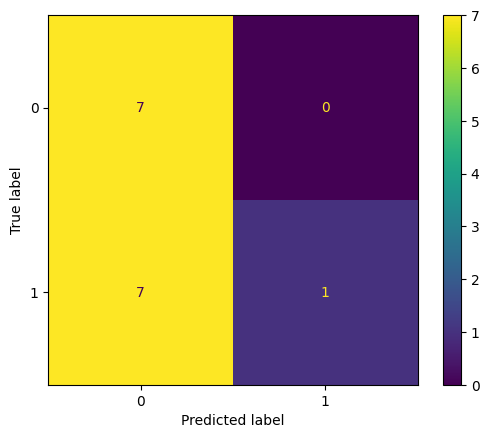

In [13]:
# Confusion Matrix
cm = confusion_matrix(human_annotations_short, model_coding, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()